# In this tutorial we will build basic CNN for image classification and then perform few test to understand overall working on CNN.
Author :- Dr. Ankur Mali -- (Intro to DL - USF)
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(1234)
np.random.seed(1234)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_val = x_train[45000:50000]
y_val = y_train[45000:50000]
x_train = x_train[0:45000]
y_train = y_train[0:45000]
x_train = x_train.astype(np.float32).reshape(-1,32,32,3) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,32,32,3) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,32,32,3) / 255.0
mean=0
sigma=0.05
gaussian = np.random.normal(mean, sigma, (32, 32))
x_test_noise=np.zeros((len(x_test),32,32,3))
x_test_noise1=np.zeros((len(x_test),32,32,3))

# noise overlaid over image
x_test_noise[:,:,:,0] = x_test[:,:,:,0] + gaussian
x_test_noise[:,:,:,1] = x_test[:,:,:,1] + gaussian
x_test_noise[:,:,:,2] = x_test[:,:,:,2] + gaussian
x_test_noise = x_test_noise.astype(np.float32)

## Important, since this is after normalization, It is very important to clip values
x_test_noise = np.clip(x_test_noise,0,1)

# noise multiplied by image:
x_test_noise1[:,:,:,0] = x_test[:,:,:,0] * gaussian
x_test_noise1[:,:,:,1] = x_test[:,:,:,1] * gaussian
x_test_noise1[:,:,:,2] = x_test[:,:,:,2] * gaussian
#x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)


y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)

test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)
print(len(train_dataset))
print(len(test_dataset))

170498071/170498071 [==============================] - 9s 0us/step
(45000, 32, 32, 3)
(10000, 32, 32, 3)
(5000, 32, 32, 3)
352
79


# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [4]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None, checkpoint_prefix = None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(512, 5, padding='same', activation=None,kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.conv2 = tf.keras.layers.Conv2D(256, 5,padding='same', activation=None,kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv5 = tf.keras.layers.Conv2D(256, 5, padding='same', activation=None,kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.conv6 = tf.keras.layers.Conv2D(128, 5, padding='same', activation=None,kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.conv3 = tf.keras.layers.Conv2D(64, 5, padding='same', activation=None,kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.conv4 = tf.keras.layers.Conv2D(64, 5, padding='same', activation=None, kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None, kernel_regularizer =tf.keras.regularizers.l2( l2=0.001))
        self.drop = tf.keras.layers.Dropout(.2)
        # self.conv1 = tf.keras.layers.Conv2D(256, 3, padding='same', activation=None)
        # self.conv2 = tf.keras.layers.Conv2D(256, 3,padding='same', activation=None)
        # self.pool1 = tf.keras.layers.MaxPool2D()
        # self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', activation=None)
        # self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.checkpoint_prefix = checkpoint_prefix
        self.acc = tf.keras.metrics.Accuracy()

    #@tf.function
    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        # x = self.conv1(images)
        # x = tf.nn.relu(x)
        # x = self.pool1(x)
        # x = self.conv2(x)
        # x = tf.nn.relu(x)
        # x = self.pool1(x)
        # x = self.conv3(x)
        # x = tf.nn.relu(x)
        # x = self.pool1(x)
        # x = self.conv4(x)
        # x = tf.nn.relu(x)
        # x = self.pool1(x)
        # x = self.conv8(x)
        # x = self.pool1(x)
        # x = tf.reshape(x, (-1, 1, 10))
        value = training
        x = self.conv3(images)
        x = tf.nn.relu(x)
        x = self.drop(x, training=value)
        x = self.pool1(x)
        x = self.conv4(x)
        x = tf.nn.relu(x)
        x = self.drop(x, training=value)
        x = self.pool1(x)
 
        x = self.conv5(x)
        x = self.conv6(x)
        x = tf.nn.relu(x)
        x = self.drop(x, training=value)
        x = self.pool1(x)
    
        x = self.conv2(x)
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.drop(x, training=value)
        x = self.pool1(x)
        x = self.conv8(x)
        x = self.pool1(x)

        x = tf.reshape(x, (-1, 1, 10))
        return x


    @tf.function
    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss

    @tf.function
    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)

    
    @tf.function
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    @tf.function
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        
        # tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
        #                                global_step=global_step)   
        return None
    
    @tf.function
    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        self.acc.reset_states()
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result()
            #result = self.acc.result().numpy()

        return result


    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False, ckpoint=None):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999.99
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result())
                self.history['train_acc'].append(acc_train.result())
                #self.history['train_loss'].append(train_loss.result().numpy())
                #self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result())
                self.history['val_acc'].append(acc_val.result())
                # self.history['eval_loss'].append(eval_loss.result().numpy())
                # self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                # print(train_loss.result())
                # print('Train loss at epoch %d: ' %(i+1), train_loss.result())
                # print('Train Acc at epoch %d: ' %(i+1), acc_train.result())
                    
                # print('Eval loss at epoch %d: ' %(i+1), eval_loss.result())
                # print('Eval Acc at epoch %d: ' %(i+1), acc_val.result())
                
                train_loss.reset_states()
                acc_train.reset_states()
                eval_loss.reset_states()
                acc_val.reset_states()
                #Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])
                    print('Model Saved')
                    ckpoint.save(file_prefix=self.checkpoint_prefix)
                    #self.save_model()

                # Check for early stopping
                count = 0 
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break


    def predict_fc(self, test_data):
      # Initialize classes to update the mean loss of train and eval
        test_loss = tf.keras.metrics.Mean('train_loss')
        acc_test = tf.keras.metrics.Mean('test_acc')
        
        
        # Begin training
        with tf.device(self.device):
          for step, (images, target) in enumerate(test_data):
              loss = self.loss_fn(images, target, False)
              accuracy = self.compute_accuracy_2(images,target)
              acc_test(accuracy)
              test_loss(loss)
        print("test_accuracy %d", acc_test.result())
        print("test_loss %d", test_loss.result())
        test_loss.reset_states()
        acc_test.reset_states()
            
                
                



In [5]:
import os
# Specify the path where you want to save/restore the trained variables.
#sample_data
checkpoint_directory = '/content/models_checkpoints/'
#checkpoint_directory = "/tmp/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory, checkpoint_prefix = checkpoint_prefix)


### This example is modified to work with Tensorflow > 2.6

## Create checkpoint to save your model
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
## Now store the initial checkpoint - at random initialization
checkpoint.save(file_prefix=checkpoint_prefix)

'/content/models_checkpoints/ckpt-1'

In [6]:
# Train model
# Pass the saver object to save model each epoch -- You can change the rule/scheme for saving the model
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True, ckpoint = checkpoint)

Train loss at epoch 1:  tf.Tensor(1.5773374, shape=(), dtype=float32)
Train Acc at epoch 1:  tf.Tensor(0.48397797, shape=(), dtype=float32)
Eval loss at epoch 1:  tf.Tensor(1.5792665, shape=(), dtype=float32)
Eval Acc at epoch 1:  tf.Tensor(0.4855469, shape=(), dtype=float32)
Model Saved
Train loss at epoch 2:  tf.Tensor(1.3826978, shape=(), dtype=float32)
Train Acc at epoch 2:  tf.Tensor(0.56654435, shape=(), dtype=float32)
Eval loss at epoch 2:  tf.Tensor(1.3852445, shape=(), dtype=float32)
Eval Acc at epoch 2:  tf.Tensor(0.5605469, shape=(), dtype=float32)
Model Saved
Train loss at epoch 4:  tf.Tensor(1.1361884, shape=(), dtype=float32)
Train Acc at epoch 4:  tf.Tensor(0.6659367, shape=(), dtype=float32)
Eval loss at epoch 4:  tf.Tensor(1.1633284, shape=(), dtype=float32)
Eval Acc at epoch 4:  tf.Tensor(0.6482422, shape=(), dtype=float32)
Model Saved
Train loss at epoch 6:  tf.Tensor(0.9343858, shape=(), dtype=float32)
Train Acc at epoch 6:  tf.Tensor(0.72302127, shape=(), dtype=flo

In [7]:
model.predict_fc(test_dataset) ## Test with simple model

test_accuracy %d tf.Tensor(0.75336236, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.7123952, shape=(), dtype=float32)


In [8]:
model.predict_fc(test_dataset_noise) ## Test with added noise

test_accuracy %d tf.Tensor(0.6806764, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.9364125, shape=(), dtype=float32)


In [9]:
model.predict_fc(test_dataset_noise1)

test_accuracy %d tf.Tensor(0.10096914, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.7937062, shape=(), dtype=float32)


In [10]:
mean=0
sigma=0.5
gaussian = np.random.normal(mean, sigma, (32, 32,3))
x_test_noise = x_test + gaussian
x_test_noise = x_test_noise.astype(np.float32)
x_test_noise = np.clip(x_test_noise,0,1)
x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)

test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)

model.predict_fc(test_dataset_noise)
model.predict_fc(test_dataset_noise1)

test_accuracy %d tf.Tensor(0.120648734, shape=(), dtype=float32)
test_loss %d tf.Tensor(9.17297, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.16159019, shape=(), dtype=float32)
test_loss %d tf.Tensor(4.642983, shape=(), dtype=float32)


In [14]:
mean=0
sigma=0.02
gaussian = np.random.normal(mean, sigma, (32, 32,3))
x_test_noise = x_test + gaussian
x_test_noise = x_test_noise.astype(np.float32)
x_test_noise = np.clip(x_test_noise,0,1)
x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)

test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)

model.predict_fc(test_dataset_noise)
model.predict_fc(test_dataset_noise1)

test_accuracy %d tf.Tensor(0.7488133, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.72875464, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.10096914, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.4888723, shape=(), dtype=float32)


In [13]:
## This is of no use, this is simply addding 0.001 to your prior values, so 0.922 will become 0.923
mean=0
sigma=0.001
gaussian = np.random.normal(mean, sigma, (32, 32,3))
x_test_noise = x_test + gaussian
x_test_noise = x_test_noise.astype(np.float32)
x_test_noise = np.clip(x_test_noise,0,1)
x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)

test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)

model.predict_fc(test_dataset_noise)
model.predict_fc(test_dataset_noise1)

test_accuracy %d tf.Tensor(0.75306565, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.71243596, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.10096914, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.325402, shape=(), dtype=float32)


Let's look at Trial-2

In [15]:
import os
tf.random.set_seed(1234)
np.random.seed(1234)
# Specify the path where you want to save/restore the trained variables.
#sample_data
checkpoint_directory = '/content/models_checkpoints_trial2/'
#checkpoint_directory = "/tmp/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory, checkpoint_prefix = checkpoint_prefix)


### This example is modified to work with Tensorflow > 2.6

## Create checkpoint to save your model
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
## Now store the initial checkpoint - at random initialization
checkpoint.save(file_prefix=checkpoint_prefix)

'/content/models_checkpoints_trial2/ckpt-1'

In [16]:
# Train model
# Pass the saver object to save model each epoch -- You can change the rule/scheme for saving the model
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True, ckpoint = checkpoint)

Train loss at epoch 1:  tf.Tensor(1.5569384, shape=(), dtype=float32)
Train Acc at epoch 1:  tf.Tensor(0.5034106, shape=(), dtype=float32)
Eval loss at epoch 1:  tf.Tensor(1.5590812, shape=(), dtype=float32)
Eval Acc at epoch 1:  tf.Tensor(0.49902344, shape=(), dtype=float32)
Model Saved
Train loss at epoch 2:  tf.Tensor(1.3352306, shape=(), dtype=float32)
Train Acc at epoch 2:  tf.Tensor(0.5914664, shape=(), dtype=float32)
Eval loss at epoch 2:  tf.Tensor(1.3401217, shape=(), dtype=float32)
Eval Acc at epoch 2:  tf.Tensor(0.5966797, shape=(), dtype=float32)
Model Saved
Train loss at epoch 4:  tf.Tensor(1.0903828, shape=(), dtype=float32)
Train Acc at epoch 4:  tf.Tensor(0.668171, shape=(), dtype=float32)
Eval loss at epoch 4:  tf.Tensor(1.1172391, shape=(), dtype=float32)
Eval Acc at epoch 4:  tf.Tensor(0.6564453, shape=(), dtype=float32)
Model Saved
Train loss at epoch 6:  tf.Tensor(0.93921477, shape=(), dtype=float32)
Train Acc at epoch 6:  tf.Tensor(0.7144344, shape=(), dtype=float

In [17]:
model.predict_fc(test_dataset) ## Performance of model without any noise
mean=0
sigma=0.05
gaussian = np.random.normal(mean, sigma, (32, 32,3))
x_test_noise = x_test + gaussian
x_test_noise = x_test_noise.astype(np.float32)
x_test_noise = np.clip(x_test_noise,0,1)
x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)

test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)
print("Now Let's look at model performance with noise -- Adding noise = Image * Noise")
model.predict_fc(test_dataset_noise)
model.predict_fc(test_dataset_noise1)

test_accuracy %d tf.Tensor(0.753659, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.71724206, shape=(), dtype=float32)
Now Let's look at model performance with noise -- Adding noise = Image * Noise
test_accuracy %d tf.Tensor(0.6871044, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.90565354, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.10096914, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.332304, shape=(), dtype=float32)


In [18]:
mean=0
sigma=0.01
gaussian = np.random.normal(mean, sigma, (32, 32))
x_test_noise=np.zeros((len(x_test),32,32,3))
x_test_noise1=np.zeros((len(x_test),32,32,3))

# noise overlaid over image
x_test_noise[:,:,:,0] = x_test[:,:,:,0] + gaussian
x_test_noise[:,:,:,1] = x_test[:,:,:,1] + gaussian
x_test_noise[:,:,:,2] = x_test[:,:,:,2] + gaussian
x_test_noise = x_test_noise.astype(np.float32)

## Important, since this is after normalization, It is very important to clip values
x_test_noise = np.clip(x_test_noise,0,1)

# noise multiplied by image:
x_test_noise1[:,:,:,0] = x_test[:,:,:,0] * gaussian
x_test_noise1[:,:,:,1] = x_test[:,:,:,1] * gaussian
x_test_noise1[:,:,:,2] = x_test[:,:,:,2] * gaussian
#x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)
test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)
print("Now Let's look at model performance with noise -- Adding noise = Image * Noise")
model.predict_fc(test_dataset_noise)
model.predict_fc(test_dataset_noise1)

Now Let's look at model performance with noise -- Adding noise = Image * Noise
test_accuracy %d tf.Tensor(0.7522745, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.7229411, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.10096914, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.3486474, shape=(), dtype=float32)


In [19]:
## This is of no use, this is simply addding 0.001 to your prior values, so 0.922 will become 0.923
mean=0
sigma=0.001
gaussian = np.random.normal(mean, sigma, (32, 32,3))
 
x_test_noise = x_test + gaussian
x_test_noise = x_test_noise.astype(np.float32)
x_test_noise = np.clip(x_test_noise,0,1)
x_test_noise1 = x_test * gaussian
x_test_noise1 = x_test_noise1.astype(np.float32)
x_test_noise1 = np.clip(x_test_noise1,0,1)

test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)

model.predict_fc(test_dataset_noise)
model.predict_fc(test_dataset_noise1)

test_accuracy %d tf.Tensor(0.753659, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.7172456, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.10096914, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.3129952, shape=(), dtype=float32)


In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [26]:
img = cv2.imread('/content/test.jpeg')

In [27]:
img = img / 255.0
img.shape

(372, 640, 3)

In [31]:
mean=0
sigma=0.05

gaussian  =  np.random.normal(loc=0, scale=0.05, size=img.shape)
# noise overlaid over image
noisy_img1 = np.clip((img + gaussian*0.05),0,1)
noisy_img2 = np.clip((img + gaussian*0.02),0,1)

# noise multiplied by image:
# whites can go to black but blacks cannot go to white
noisy_img_mul1 = np.clip((img*(1 + gaussian*0.4)),0,1)
noisy_img_mul2 = np.clip((img*(1 + gaussian)),0,1)


noisy_img3 = np.clip((img + gaussian),0,1) ## This is our image when we add it
noisy_img_mul3 = np.clip((img*(gaussian)),0,1) ## This is our image when we multiply it

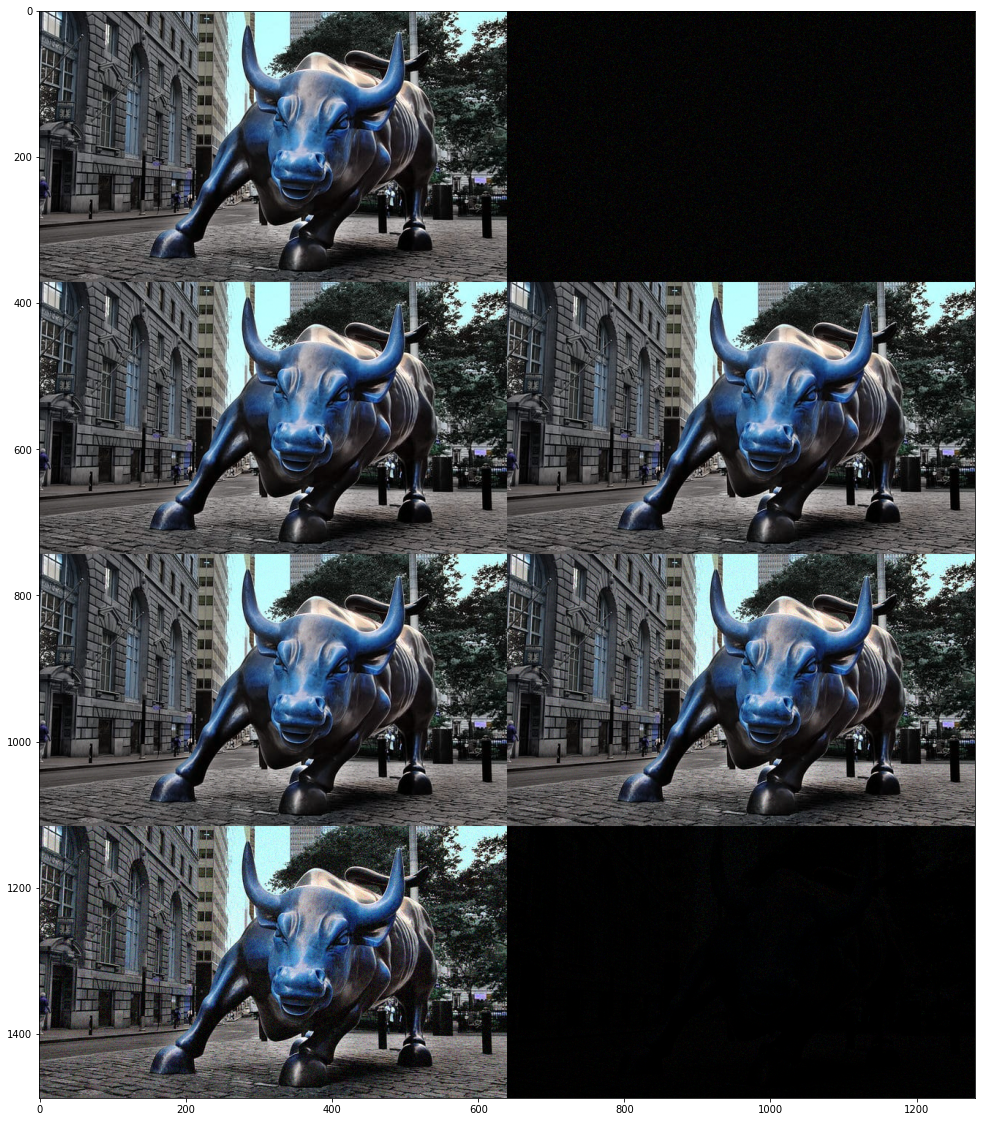

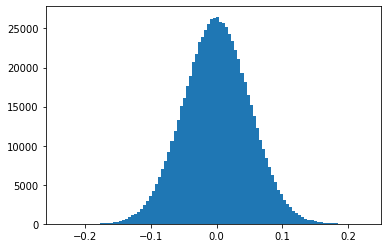

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(np.vstack((np.hstack((img, gaussian)),
                      np.hstack((noisy_img1, noisy_img2)),
                      np.hstack((noisy_img_mul1, noisy_img_mul2)),
                      np.hstack((noisy_img3, noisy_img_mul3)))))
plt.show()
plt.hist(gaussian.ravel(), bins=100)
plt.show()

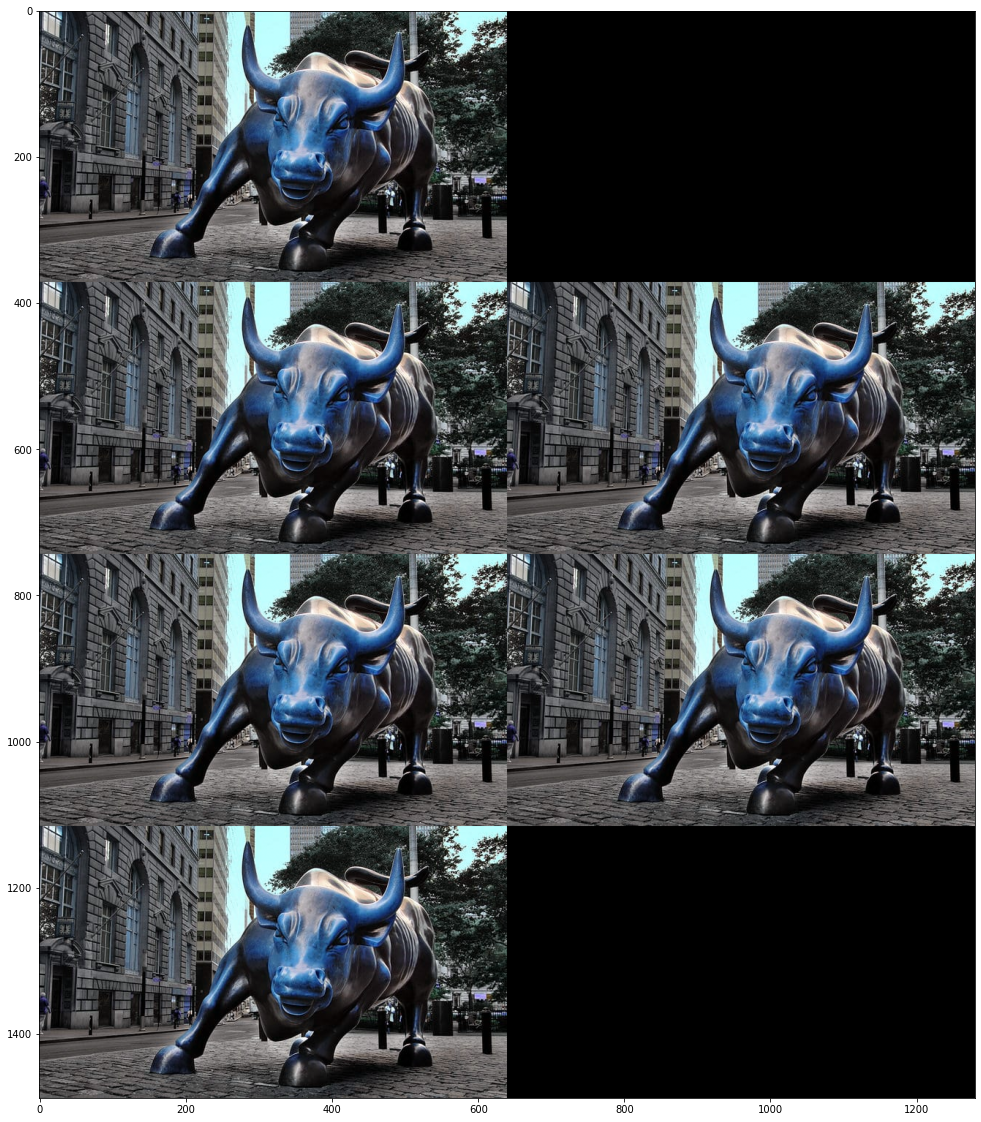

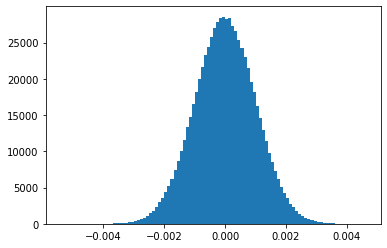

In [42]:
mean=0
sigma=0.001

gaussian  =  np.random.normal(loc=mean, scale=sigma, size=img.shape)
# noise overlaid over image
noisy_img1 = np.clip((img + gaussian*0.05),0,1)
noisy_img2 = np.clip((img + gaussian*0.02),0,1)

# noise multiplied by image:
# whites can go to black but blacks cannot go to white
noisy_img_mul1 = np.clip((img*(1 + gaussian*0.4)),0,1)
noisy_img_mul2 = np.clip((img*(1 + gaussian*0.8)),0,1)


noisy_img3 = np.clip((img + gaussian),0,1) ## This is our image when we add it
noisy_img_mul3 = np.clip((img*(gaussian)),0,1) ## This is our image when we multiply it

plt.figure(figsize=(20,20))
plt.imshow(np.vstack((np.hstack((img, gaussian)),
                      np.hstack((noisy_img1, noisy_img2)),
                      np.hstack((noisy_img_mul1, noisy_img_mul2)),
                      np.hstack((noisy_img3, noisy_img_mul3)))))
plt.show()
plt.hist(gaussian.ravel(), bins=100)
plt.show()

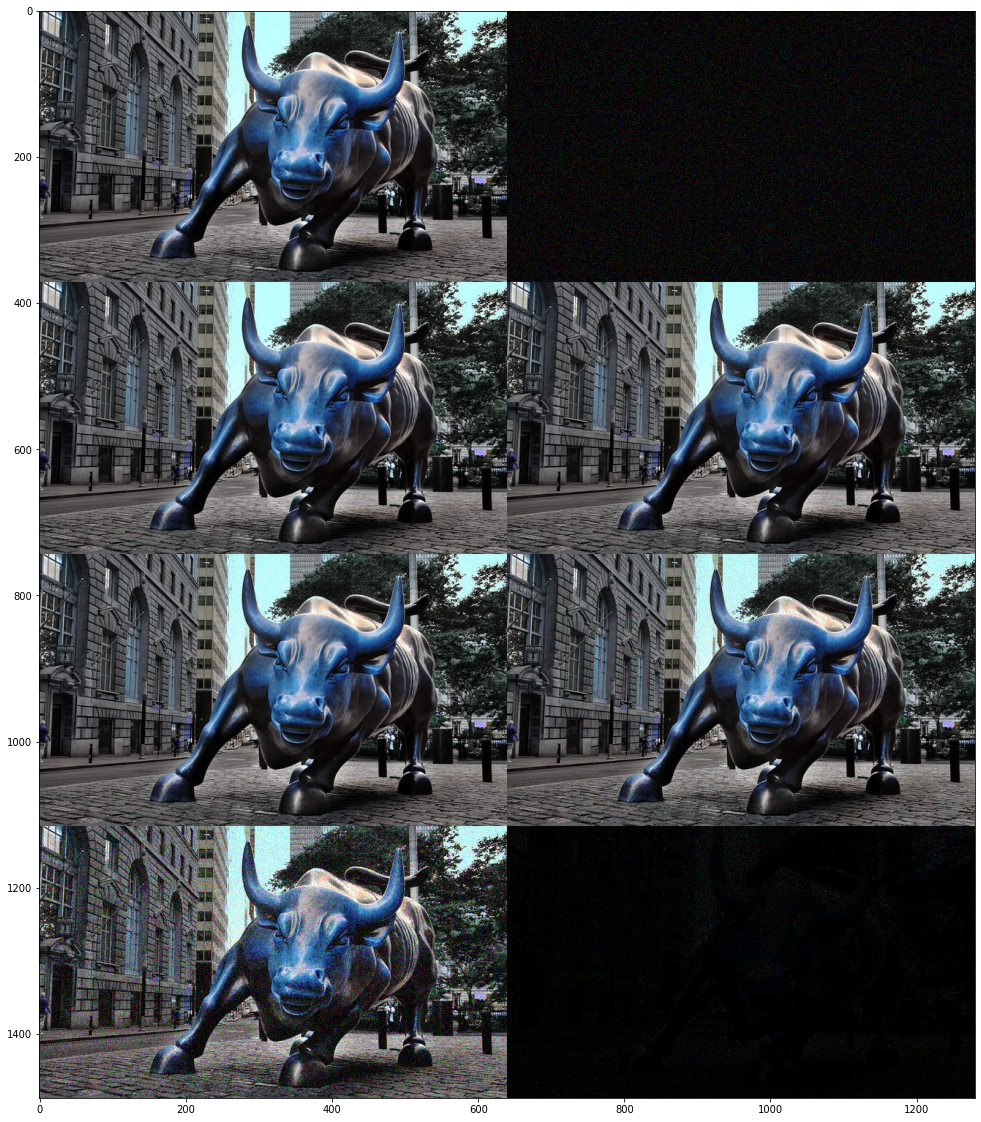

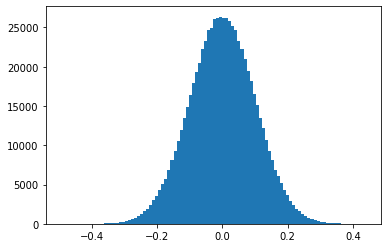

In [43]:
mean=0
sigma=0.1

gaussian  =  np.random.normal(loc=0, scale=0.1, size=img.shape)
# noise overlaid over image
noisy_img1 = np.clip((img + gaussian*0.05),0,1)
noisy_img2 = np.clip((img + gaussian*0.02),0,1)

# noise multiplied by image:
# whites can go to black but blacks cannot go to white
noisy_img_mul1 = np.clip((img*(1 + gaussian*0.4)),0,1)
noisy_img_mul2 = np.clip((img*(1 + gaussian*0.8)),0,1)


noisy_img3 = np.clip((img + gaussian),0,1) ## This is our image when we add it
noisy_img_mul3 = np.clip((img*(gaussian)),0,1) ## This is our image when we multiply it

plt.figure(figsize=(20,20))
plt.imshow(np.vstack((np.hstack((img, gaussian)),
                      np.hstack((noisy_img1, noisy_img2)),
                      np.hstack((noisy_img_mul1, noisy_img_mul2)),
                      np.hstack((noisy_img3, noisy_img_mul3)))))
plt.show()
plt.hist(gaussian.ravel(), bins=100)
plt.show()

In [40]:
mean=0
sigma=0.1
gaussian = np.random.normal(mean, sigma, (32, 32,3))
x_test_noise = np.clip((x_test + gaussian),0,1)
x_test_noise1 = np.clip((x_test*(gaussian)),0,1)

x_test_noise = x_test_noise.astype(np.float32)

x_test_noise1 = x_test_noise1.astype(np.float32)


x_test_noise2 = np.clip((x_test*(1 + gaussian*0.4)),0,1)
x_test_noise3= np.clip((x_test*(1 + gaussian*0.8)),0,1)

x_test_noise2 = x_test_noise2.astype(np.float32)
x_test_noise2 = x_test_noise2.astype(np.float32)
test_dataset_noise = tf.data.Dataset.from_tensor_slices((x_test_noise, y_test))
test_dataset_noise = test_dataset_noise.batch(128)
test_dataset_noise1 = tf.data.Dataset.from_tensor_slices((x_test_noise1, y_test))
test_dataset_noise1 = test_dataset_noise1.batch(128)

test_dataset_noise2 = tf.data.Dataset.from_tensor_slices((x_test_noise2, y_test))
test_dataset_noise2 = test_dataset_noise2.batch(128)

test_dataset_noise3 = tf.data.Dataset.from_tensor_slices((x_test_noise3, y_test))
test_dataset_noise3 = test_dataset_noise3.batch(128)

model.predict_fc(test_dataset_noise) ## Similar to Image - 7
model.predict_fc(test_dataset_noise1) ## Similar to Image - 8
model.predict_fc(test_dataset_noise2) ## Similar to Image - 5
model.predict_fc(test_dataset_noise3) ##Similar to Image - 6

test_accuracy %d tf.Tensor(0.4909019, shape=(), dtype=float32)
test_loss %d tf.Tensor(1.6380073, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.10007911, shape=(), dtype=float32)
test_loss %d tf.Tensor(3.13837, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.7475277, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.7368077, shape=(), dtype=float32)
test_accuracy %d tf.Tensor(0.70935524, shape=(), dtype=float32)
test_loss %d tf.Tensor(0.8443137, shape=(), dtype=float32)
